In [6]:
import numpy as np
import matplotlib.pyplot as plt
import gzip ## gz 파일을 
from pytorchcv import load_mnist, display_dataset

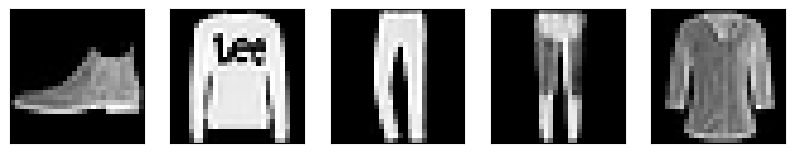

In [7]:
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 28, 28)
    return data

# MNIST 데이터셋 불러오기
images = load_mnist_images('./원래 있던 데이터/t10k-images-idx3-ubyte.gz')

# 이미지 출력
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for idx, image in enumerate(images[:5]):
    axes[idx].imshow(image, cmap='gray')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
plt.show()


In [8]:
from pytorchcv import load_mnist, display_dataset
load_mnist(batch_size=128)

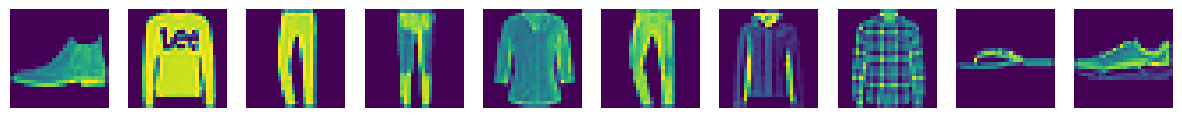

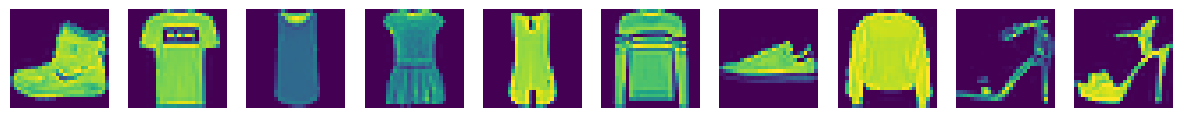

In [9]:
display_dataset(data_test)
display_dataset(data_train)

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

NameError: name 'torch' is not defined